In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import xml.etree.ElementTree as ET
from timeit import default_timer as timer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearnex import patch_sklearn

2024-10-23 19:18:57.667714: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 19:18:57.668742: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 19:18:57.698373: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 19:18:57.954396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 19:18:58.517097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
# Baixar o arquivo com wget
#!wget --output-document=/home/lavid/JOAO/archive.zip https://www.kaggle.com/api/v1/datasets/download/blanderbuss/parking-lot-dataset

# Extrair o arquivo
#!unzip /home/lavid/JOAO/archive.zip -d /home/lavid/JOAO/

# Remover o arquivo ZIP
#!rm /home/lavid/JOAO/archive.zip


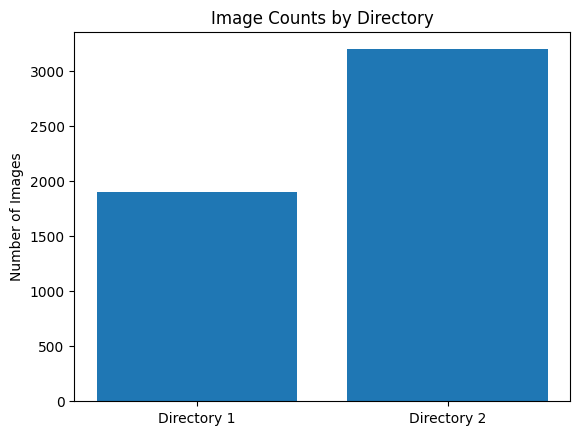

In [3]:
# Utilize o caminho correto retornado pelo kagglehub
base_path = '/home/lavid/JOAO'  # Este é o caminho do dataset baixado que você obteve

# Agora, defina os caminhos para os diretórios de "Empty" e "Occupied"
dir1_path = f"{base_path}/PKLot/PKLotSegmented/PUC/Cloudy/2012-09-12/Empty"
dir2_path = f"{base_path}/PKLot/PKLotSegmented/PUC/Cloudy/2012-09-12/Occupied"

# Obter o número de imagens em cada diretório
dir1_count = len(os.listdir(dir1_path))
dir2_count = len(os.listdir(dir2_path))

# Plotar o número de imagens em cada diretório
fig, ax = plt.subplots()
ax.bar(["Directory 1", "Directory 2"], [dir1_count, dir2_count])
ax.set_ylabel("Number of Images")
ax.set_title("Image Counts by Directory")
plt.show()


# Read Data

In [4]:
input_shape = (100, 100, 3)

# Inicializando arrays para armazenar os dados de treino e validação (após achatamento)
x_train = np.ndarray((0, 100 * 100 * 3))  # Vetor 1D com 100*100*3 (30.000 elementos)
y_train = np.ndarray((0, 2))  # Labels categóricos
x_val = np.ndarray((0, 100 * 100 * 3))
y_val = np.ndarray((0, 2))

# Utilize o caminho correto fornecido pelo kagglehub
base_path = '/home/lavid/JOAO'  # O caminho para o dataset baixado

# Loop sobre os diretórios dentro de "Cloudy"
for folder_name in os.listdir(f'{base_path}/PKLot/PKLotSegmented/PUC/Cloudy'):
    train_dir = f"{base_path}/PKLot/PKLotSegmented/PUC/Cloudy/{folder_name}"

    # Justificativa para normalização: 
    # A normalização (rescale=1./255) é uma prática comum para redes neurais, 
    # pois garante que os dados de entrada estejam entre 0 e 1, o que ajuda o modelo a convergir mais rapidamente.
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 80% treino, 20% validação

    # Justificativa para a separação de treino/validação:
    # A divisão 80/20 é usada frequentemente para garantir que o modelo seja treinado 
    # com uma quantidade significativa de dados, enquanto reserva 20% para validação e avaliar desempenho.
    
    # Geradores de treino e validação
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=input_shape[:2],
        batch_size=256,
        class_mode='categorical',
        subset='training')  # 80% para treino

    validation_generator = datagen.flow_from_directory(
        train_dir,
        target_size=input_shape[:2],
        batch_size=256,
        class_mode='categorical',
        subset='validation')  # 20% para validação

    # Carregar um lote de treino e validação
    x_tr, y_tr = next(train_generator)
    x_v, y_v = next(validation_generator)

    # Achatar as imagens (flatten) de 3D (100x100x3) para 1D (30.000)
    x_tr_flattened = x_tr.reshape((x_tr.shape[0], -1))  # Achatar as imagens de treino
    x_v_flattened = x_v.reshape((x_v.shape[0], -1))  # Achatar as imagens de validação

    # Adicionando os dados ao array final
    x_val = np.vstack([x_val, x_v_flattened])
    y_val = np.vstack([y_val, y_v])

    x_train = np.vstack([x_train, x_tr_flattened[:500]])
    y_train = np.vstack([y_train, y_tr[:500]])

Found 12321 images belonging to 2 classes.


Found 3079 images belonging to 2 classes.
Found 10559 images belonging to 2 classes.
Found 2638 images belonging to 2 classes.
Found 10799 images belonging to 2 classes.
Found 2699 images belonging to 2 classes.
Found 4079 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.
Found 12399 images belonging to 2 classes.
Found 3099 images belonging to 2 classes.
Found 11598 images belonging to 2 classes.
Found 2898 images belonging to 2 classes.
Found 12481 images belonging to 2 classes.
Found 3119 images belonging to 2 classes.
Found 6321 images belonging to 2 classes.
Found 1579 images belonging to 2 classes.
Found 11920 images belonging to 2 classes.
Found 2980 images belonging to 2 classes.
Found 12955 images belonging to 2 classes.
Found 3238 images belonging to 2 classes.
Found 801 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [5]:
# Número de exemplos e número de features
print(f"Número de exemplos de treino: {x_train.shape[0]}")
print(f"Número de exemplos de validação: {x_val.shape[0]}")
print(f"Número de features (dimensão das imagens achatadas): {x_train.shape[1]}")

Número de exemplos de treino: 2816
Número de exemplos de validação: 2759
Número de features (dimensão das imagens achatadas): 30000


In [6]:
x_train = x_train[1:]
y_train = y_train[1:]
x_val = x_val[1:]
y_val = y_val[1:]

In [7]:
# Verificar o formato de x_train antes de continuar
print(f"Formato de x_train: {x_train.shape}")  # Formato já está 2D (n_samples, height * width * depth)

# Definir o subamostrador aleatório
rus = RandomUnderSampler(random_state=42)

# Como x_train já está achatado, podemos aplicar diretamente o RandomUnderSampler
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

# Embaralhar os dados de treinamento e rótulos reamostrados
x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=42)

# Imprimir o formato dos dados balanceados
print('Balanced training data shape:', x_train_resampled.shape, y_train_resampled.shape)

Formato de x_train: (2815, 30000)
Balanced training data shape: (2158, 30000) (2158, 1)


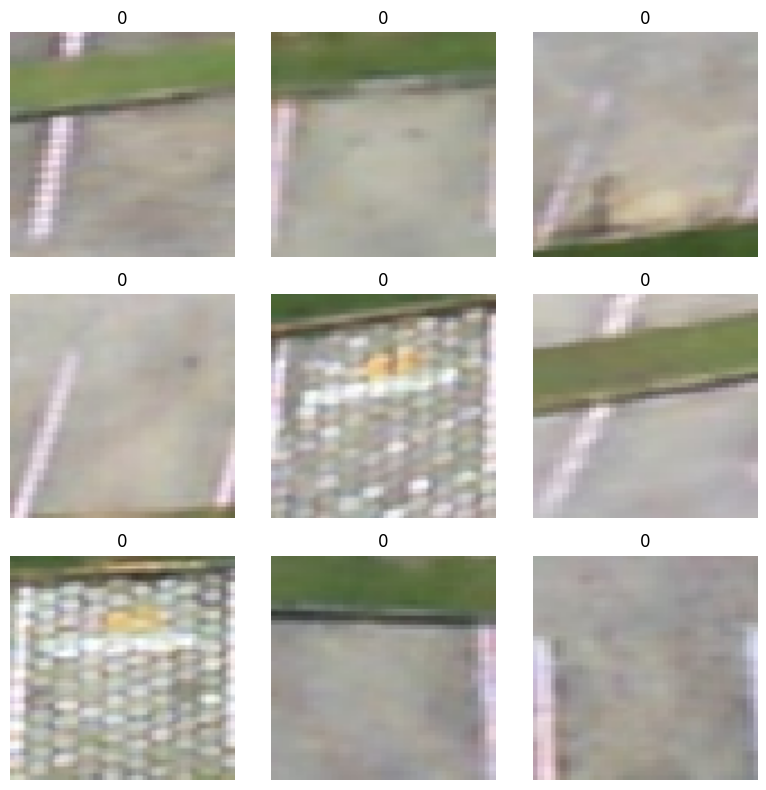

In [8]:
# Definir as dimensões originais da imagem
height, width, depth = 100, 100, 3  # 100x100 com 3 canais (RGB)

# Crie uma figura com 3 linhas e 3 colunas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# Exibir as primeiras 9 imagens em x_train
for i, ax in enumerate(axes.flat):
    # Redimensionar a imagem de volta para (100, 100, 3)
    img = x_train[i+12].reshape((height, width, depth))
    ax.imshow(img)  # Exibe a imagem a partir da posição 12
    ax.set_title(np.argmax(y_train_resampled[i+12]))  # Define o título como a classe da imagem
    ax.axis('off')  # Remove os eixos

# Mostrar a figura
plt.tight_layout()
plt.show()

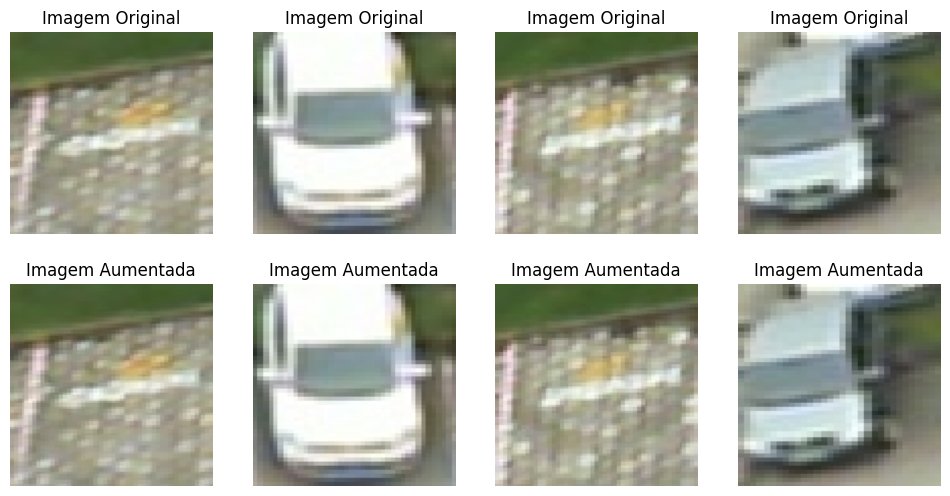

In [9]:
# Obter o primeiro lote de imagens do gerador
batch = next(train_generator)

# Extrair as imagens do lote
images = batch[0]

# Redimensionar as imagens (supondo que o lote tenha 256 imagens)
images = images.reshape((256, 100, 100, 3))

# Criar uma figura para exibir as imagens
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Exibir imagens originais e aumentadas em pares
for i in range(4):
    # Exibir imagem original
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')  # Remover os eixos
    axes[0, i].set_title('Imagem Original')

    # Aplicar aumentação à imagem e exibir a imagem transformada
    transformed_img = datagen.random_transform(images[i])
    axes[1, i].imshow(transformed_img)
    axes[1, i].axis('off')  # Remover os eixos
    axes[1, i].set_title('Imagem Aumentada')

# Mostrar a figura
plt.show()

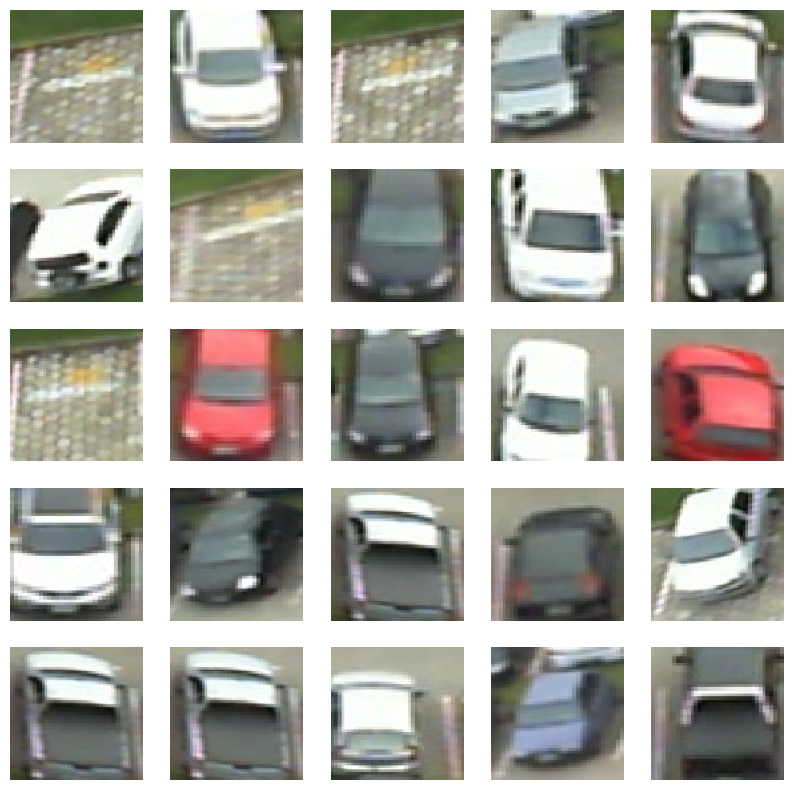

In [10]:
# Criar uma figura para exibir as imagens
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Exibir as imagens em uma matriz 5x5
for i in range(25):
    row_idx = i // 5  # Índice da linha
    col_idx = i % 5   # Índice da coluna
    axes[row_idx, col_idx].imshow(images[i])  # Exibir a imagem na posição correspondente
    axes[row_idx, col_idx].axis('off')  # Remover os eixos

# Salvar a figura em um arquivo
plt.savefig('images_matrix.png')

# Mostrar a figura
plt.show()

# Create extractor

In [11]:
def extract_parking_spaces(image_path, xml_path, save_dir='cropped_images', display_results=True, return_contours=False):
    # Carregar a imagem
    img = cv2.imread(image_path)
    img_contours = img.copy()

    # Carregar o arquivo XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Definir uma lista para armazenar as imagens cortadas
    cropped_images = []
    contours = []

    # Definir uma lista de cores para os contornos
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

    # Criar o diretório de salvamento se ele não existir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterar sobre as vagas de estacionamento no arquivo XML
    for i, space in enumerate(root.iter('space')):
        # Extrair o retângulo rotacionado e o contorno do arquivo XML
        rotated_rect = space.find('rotatedRect')
        contour = space.find('contour')
        center = rotated_rect.find('center')
        size = rotated_rect.find('size')
        angle = rotated_rect.find('angle')

        # Extrair os valores dos elementos XML
        cx, cy = int(center.attrib['x']), int(center.attrib['y'])
        w, h = int(size.attrib['w']), int(size.attrib['h'])
        angle_deg = float(angle.attrib['d'])

        # Converter o ângulo para radianos
        angle_rad = angle_deg * (3.14159 / 180)

        # Extrair os pontos do contorno
        pts = []
        for point in contour.iter('point'):
            x, y = int(point.attrib['x']), int(point.attrib['y'])
            pts.append((x, y))

        # Criar uma máscara para o polígono
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))

        # Rotacionar a máscara pelo ângulo
        M = cv2.getRotationMatrix2D((cx, cy), angle_deg, 1)
        rotated_mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))

        # Recortar a região da imagem usando a máscara rotacionada
        cropped = cv2.bitwise_and(img, img, mask=rotated_mask)

        # Encontrar a caixa delimitadora do contorno
        x, y, w, h = cv2.boundingRect(np.array(pts))
        # Cortar a região de interesse da imagem recortada
        roi = img[y:y+h, x:x+w]

        # Redimensionar a região de interesse para 100x100
        resized_roi = cv2.resize(roi, (100, 100))

        # Adicionar a imagem recortada à lista
        cropped_images.append(resized_roi)

        # Desenhar o contorno na imagem original
        cv2.drawContours(img_contours, [np.array(pts)], 0, colors[i % len(colors)], 2)

        contours.append(np.array(pts))

    # Se a opção de exibir os resultados for True, mostrar a imagem com os contornos
    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img_contours)
        plt.show()

    # Converter a lista de imagens recortadas para um array numpy
    cropped_images_array = np.array(cropped_images)

    contours = np.array(contours)

    # Se a opção de retornar os contornos for True, retornar as imagens e os contornos
    if return_contours:
        return cropped_images_array, contours

    # Retornar apenas as imagens recortadas
    return cropped_images_array

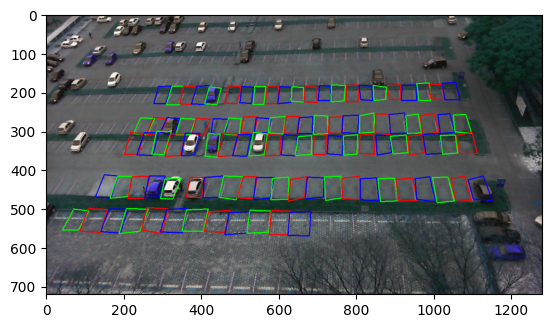

In [12]:
# Utilize o base_path ao invés de hard-code o caminho
image_path = f'{base_path}/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_07_55.jpg'
xml_path = f'{base_path}/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_07_55.xml'

# Chamar a função com os caminhos ajustados
res = extract_parking_spaces(image_path, xml_path, display_results=True)

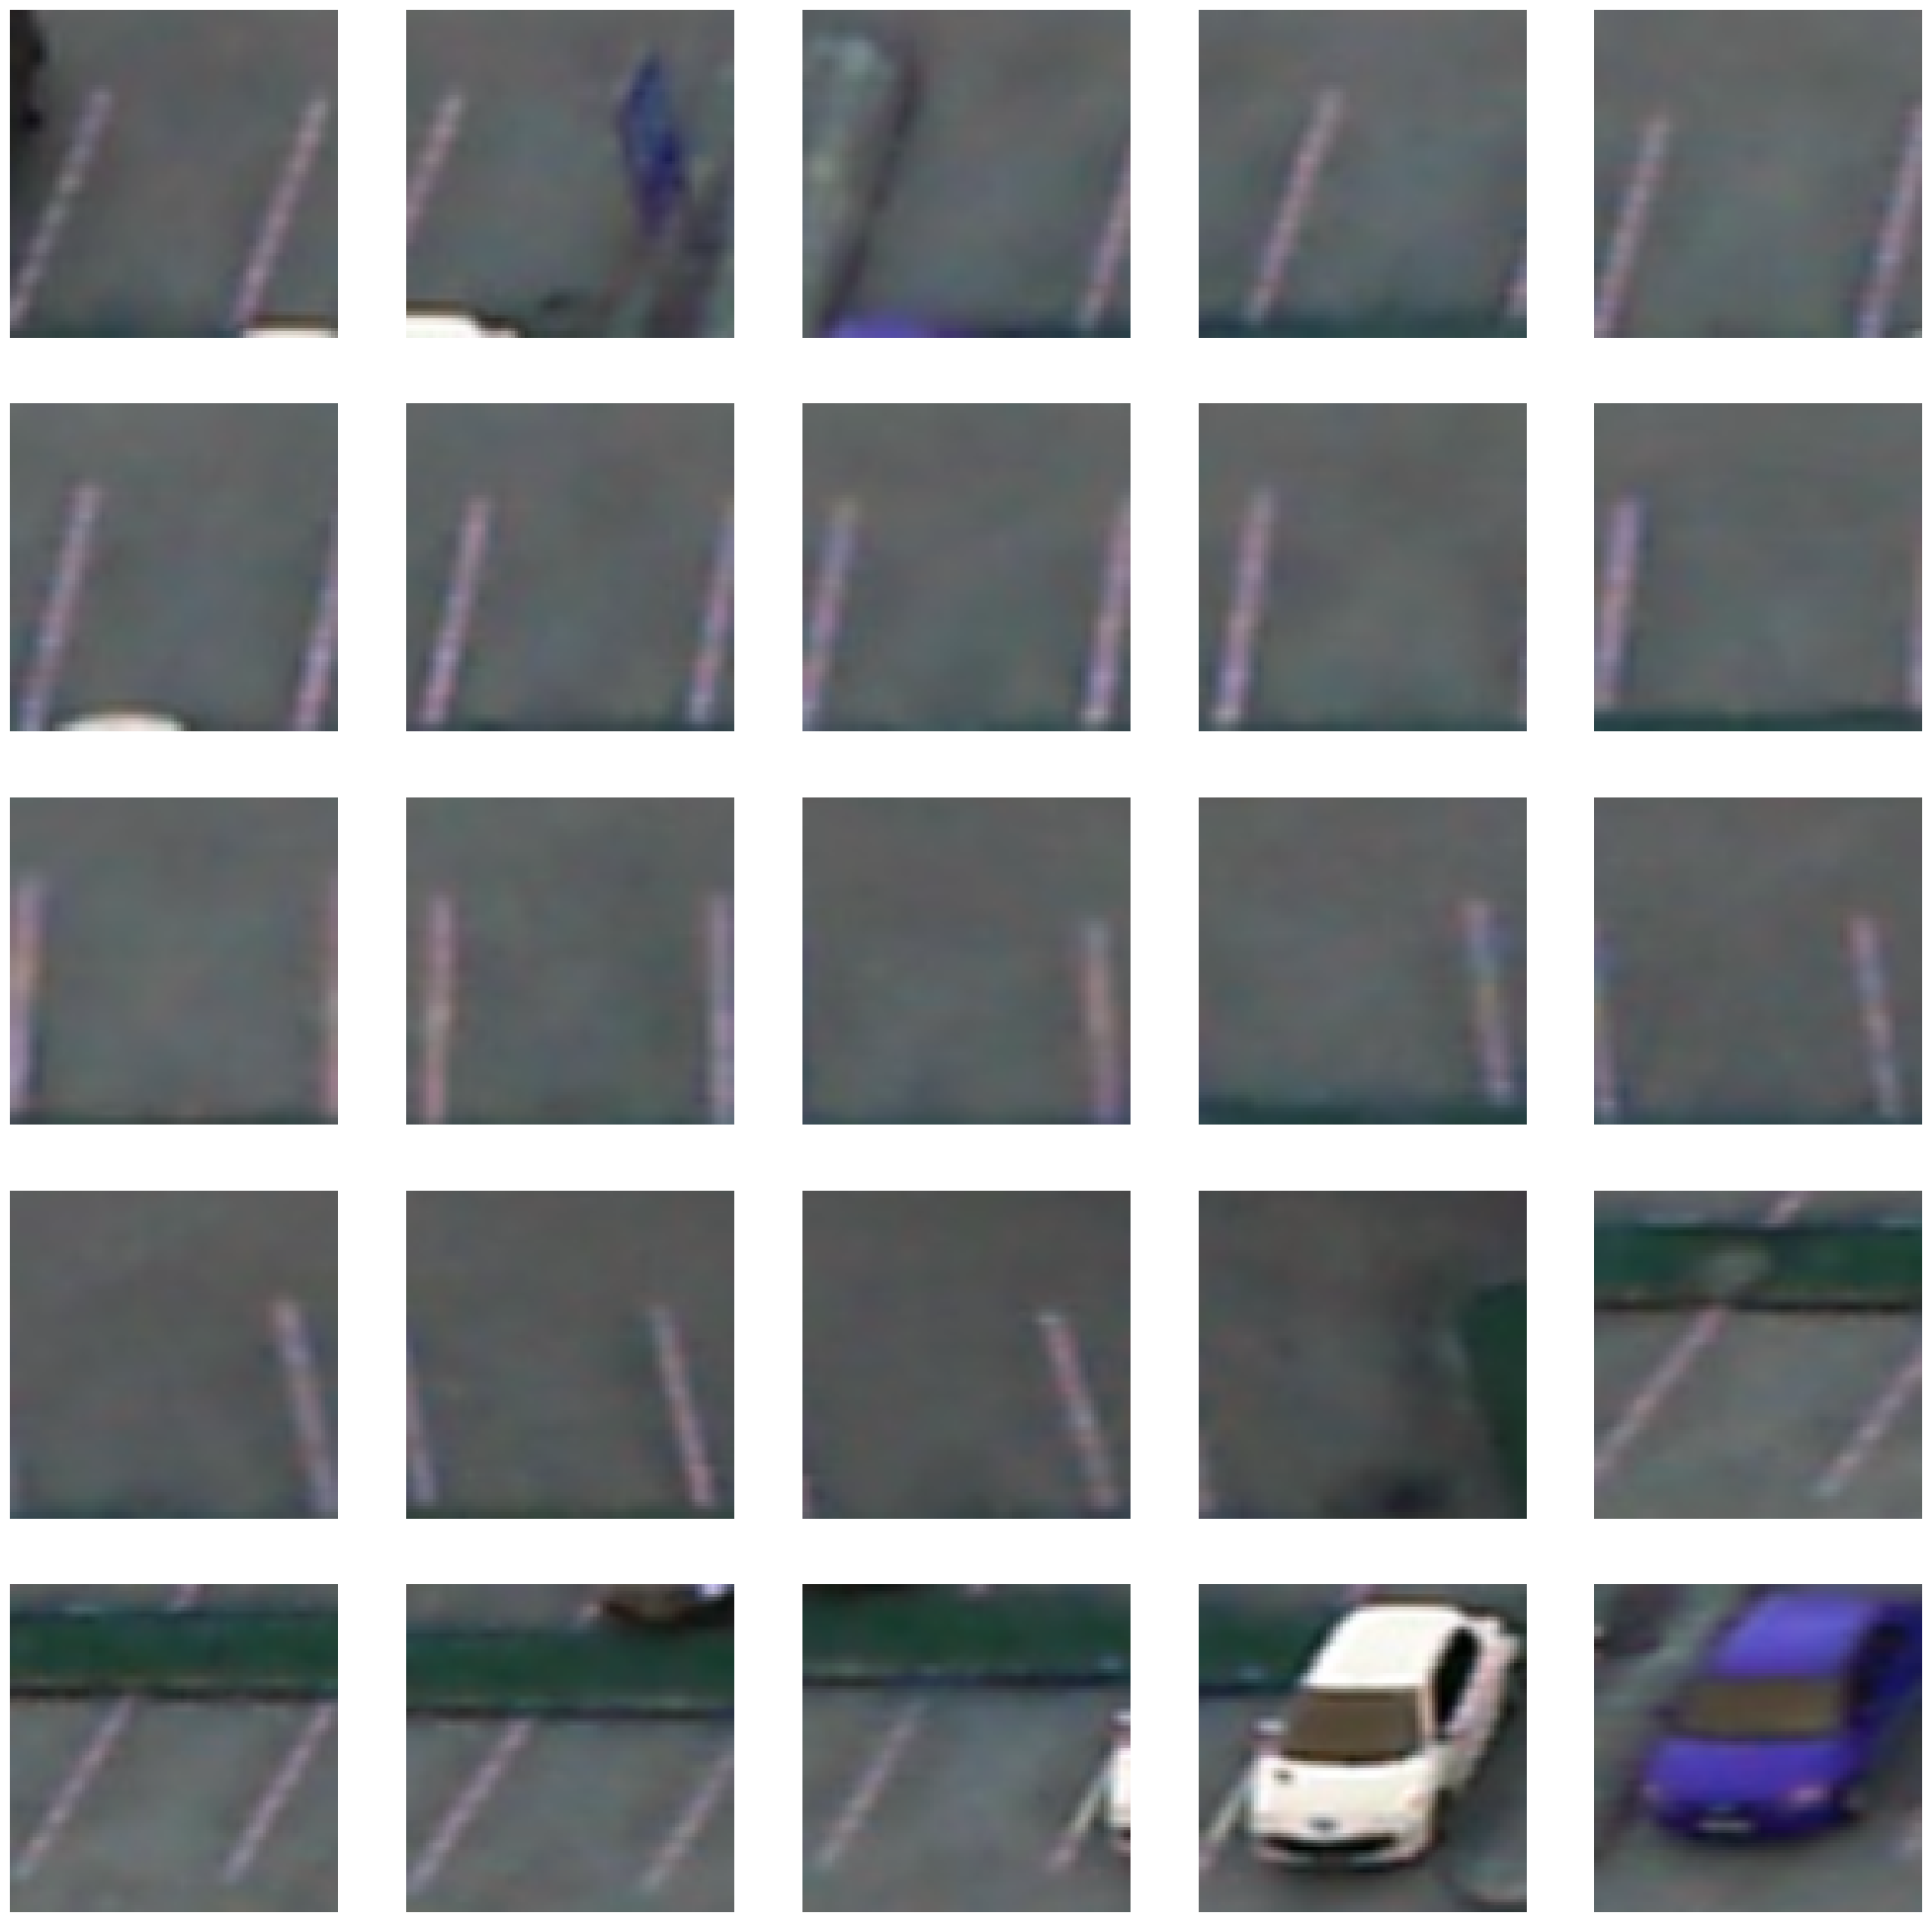

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i in range(25):
    axs[i].imshow(res[i+25])
    axs[i].axis('off')

plt.show()

# Create models

### Rede Neural

In [14]:
# Definindo a classe TimingCallback para monitorar o tempo de cada época
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs = []
    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(timer() - self.starttime)

In [15]:
# Define a arquitetura da rede neural
model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(units=64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=2, activation="softmax")
])

# Print the model summary
model.summary()

2024-10-23 19:19:04.742318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 19:19:04.742564: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     1,920,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,922,594 (7.33 MB)

 Trainable params: 1,922,402 (7.33 MB)

 Non-trainable params: 192 (768.00 B)

In [16]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(patience=25, min_delta=0.01, verbose=1, mode='min', monitor='val_loss')
reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.1, cooldown=2, verbose=1)
time_callback = TimingCallback()

In [17]:
# Hyperparameters
lr = 0.001
epochs = 50
batch_size = 256

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_learning_rate, time_callback],
    verbose=1,
)

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(x_val, y_val)
print('Validation accuracy: {:.2f}%'.format(accuracy * 100))

# Predictions
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics calculation
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7035 - loss: 0.6748 - val_accuracy: 0.6291 - val_loss: 6.3823 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8954 - loss: 0.2616 - val_accuracy: 0.6414 - val_loss: 2.6484 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9373 - loss: 0.1878 - val_accuracy: 0.7259 - val_loss: 1.2401 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9397 - loss: 0.1638 - val_accuracy: 0.8299 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9549 - loss: 0.1272 - val_accuracy: 0.9202 - val_loss: 0.2206 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9603 - loss: 0.1110 - val_accuracy: 0.9547 - val_loss: 0.1380 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9599 - loss: 0.1050 - val_acc

In [18]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Overfitting analysis
print(f"Training loss (E_in): {history.history['loss'][-1]:.4f}")
print(f"Validation loss (E_out): {history.history['val_loss'][-1]:.4f}")

Precision: 1.00
Recall: 1.00
F1-score: 1.00
Training loss (E_in): 0.0036
Validation loss (E_out): 0.0173


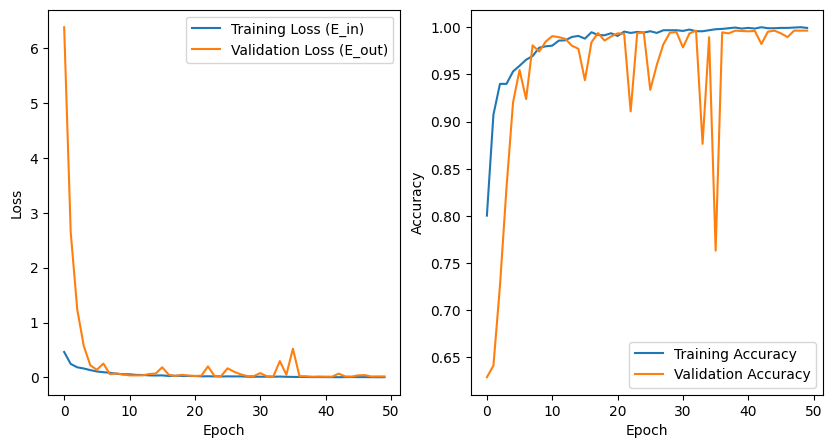

In [19]:
# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (E_in)')
plt.plot(history.history['val_loss'], label='Validation Loss (E_out)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# Justifications for batch_size and epochs
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print("O batch size de 256 foi escolhido por ser um compromisso entre velocidade de treinamento e estabilidade do gradiente.")
print("50 épocas foram escolhidas com base na observação do início da estabilização das métricas de perda e acurácia.")

Batch size: 256
Epochs: 50
O batch size de 256 foi escolhido por ser um compromisso entre velocidade de treinamento e estabilidade do gradiente.
50 épocas foram escolhidas com base na observação do início da estabilização das métricas de perda e acurácia.


In [21]:
def plot_confusion_matrix(y_true, y_pred, title=''):
    class_names = ['Occupied', 'Empty']
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy for each class

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True,fmt='d', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)

    plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


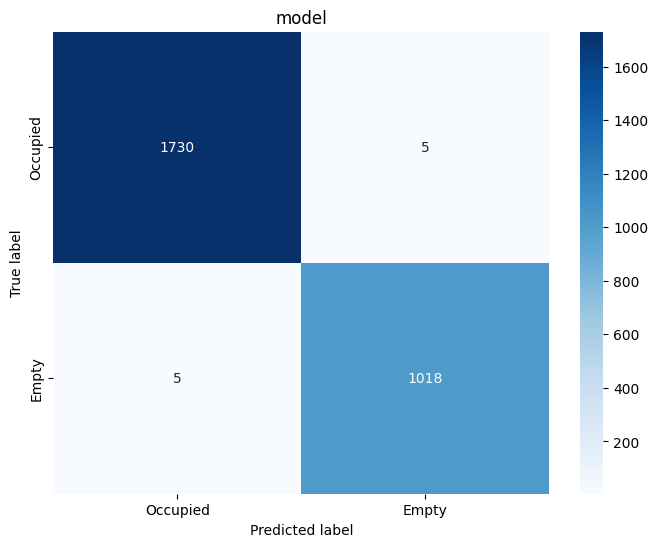

In [22]:
# Generate predictions on the validation data
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = np.argmax(y_val, axis=1)
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, title="model")

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1735
           1       1.00      1.00      1.00      1023

    accuracy                           1.00      2758
   macro avg       1.00      1.00      1.00      2758
weighted avg       1.00      1.00      1.00      2758



### Árvore de Decisão

In [24]:
# Instanciar o modelo de árvore de decisão
decision_tree_model = DecisionTreeClassifier(random_state=42)

In [25]:
# Treinar o modelo de árvore de decisão
decision_tree_model.fit(x_train, np.argmax(y_train, axis=1))

# Predições no conjunto de validação
y_pred_tree = decision_tree_model.predict(x_val)

In [26]:
# Exibir relatório de classificação
print(classification_report(np.argmax(y_val, axis=1), y_pred_tree))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1735
           1       0.98      0.96      0.97      1023

    accuracy                           0.98      2758
   macro avg       0.98      0.97      0.98      2758
weighted avg       0.98      0.98      0.98      2758



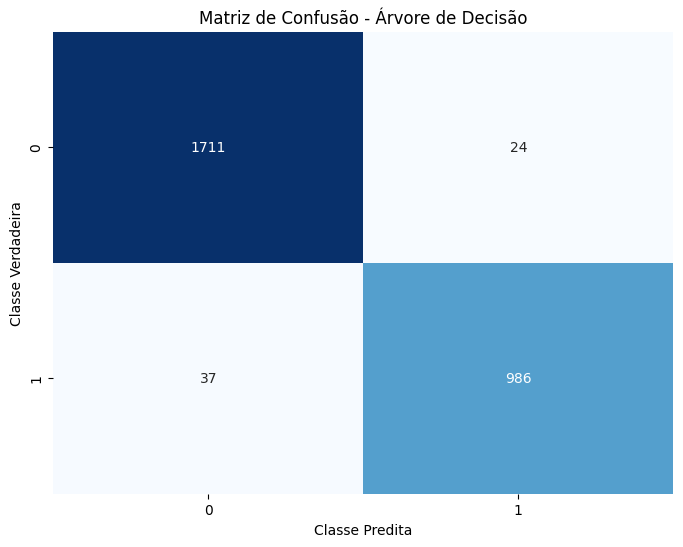

In [27]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred_tree)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()

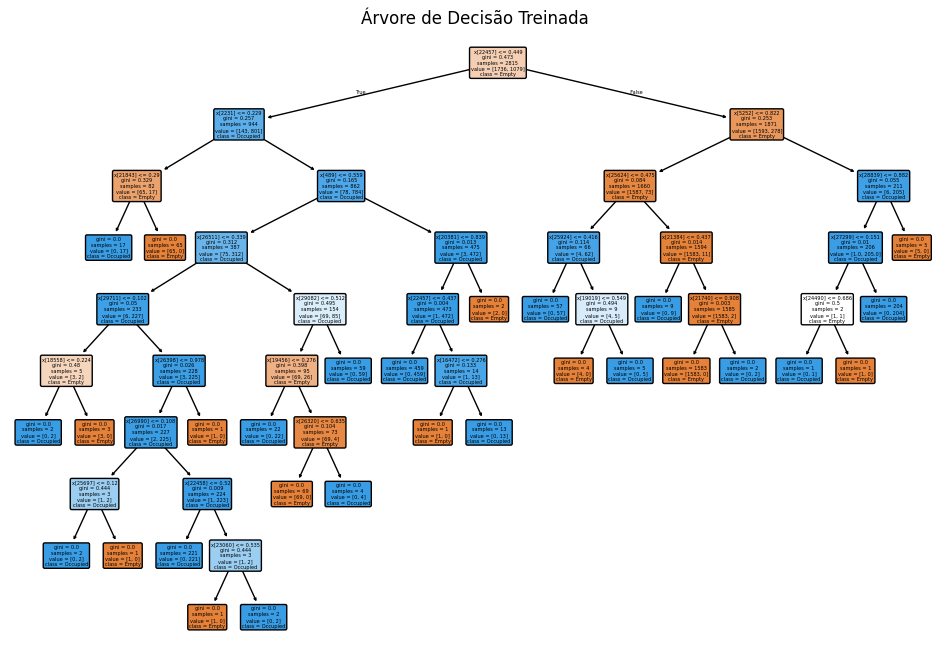

In [28]:
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_model, filled=True, feature_names=None, class_names=['Empty', 'Occupied'], rounded=True)
plt.title("Árvore de Decisão Treinada")
plt.savefig("/home/lavid/JOAO/decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()  # Exibir a figura

In [29]:
# Computar E_in e E_out
e_in = 1 - decision_tree_model.score(x_train, np.argmax(y_train, axis=1))
e_out = 1 - decision_tree_model.score(x_val, np.argmax(y_val, axis=1))
print(f"E_in (Erro no treino): {e_in:.4f}")
print(f"E_out (Erro na validação): {e_out:.4f}")

E_in (Erro no treino): 0.0000
E_out (Erro na validação): 0.0221


In [30]:
# Minimal Cost-Complexity Pruning
path = decision_tree_model.cost_complexity_pruning_path(x_train, np.argmax(y_train, axis=1))
ccp_alphas = path.ccp_alphas  # valores de α para regularização

In [31]:
# Supondo que x_train e y_train já estejam definidos
# Selecionar um subconjunto dos valores de ccp_alpha
ccp_alphas_subset = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 5)

# Instanciar o modelo de árvore de decisão com parâmetros para limitar a profundidade e amostras mínimas
trees = []
for ccp_alpha in ccp_alphas_subset:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, max_depth=10, min_samples_leaf=5)
    
    # Usar validação cruzada com múltiplos núcleos para acelerar o processo
    scores = cross_val_score(tree, x_train, np.argmax(y_train, axis=1), cv=3, n_jobs=-1)
    trees.append((tree, scores.mean()))

# Selecionar a melhor árvore com base na acurácia média
best_tree = max(trees, key=lambda x: x[1])[0]

# Treinar e avaliar a árvore final
best_tree.fit(x_train, np.argmax(y_train, axis=1))
y_pred_best_tree = best_tree.predict(x_val)

In [32]:
print("\nRelatório de Classificação da Melhor Árvore:")
print(classification_report(np.argmax(y_val, axis=1), y_pred_best_tree))


Relatório de Classificação da Melhor Árvore:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1735
           1       0.97      0.95      0.96      1023

    accuracy                           0.97      2758
   macro avg       0.97      0.97      0.97      2758
weighted avg       0.97      0.97      0.97      2758



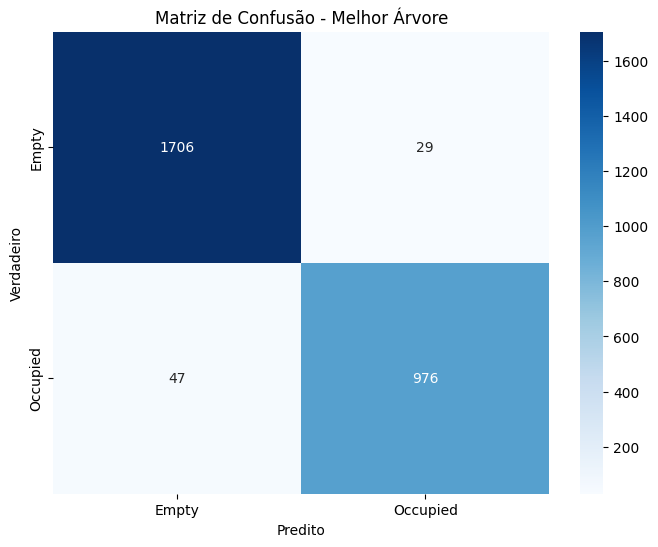

In [33]:
# Calcular a matriz de confusão
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_best_tree)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Empty', 'Occupied'], yticklabels=['Empty', 'Occupied'])
plt.title('Matriz de Confusão - Melhor Árvore')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

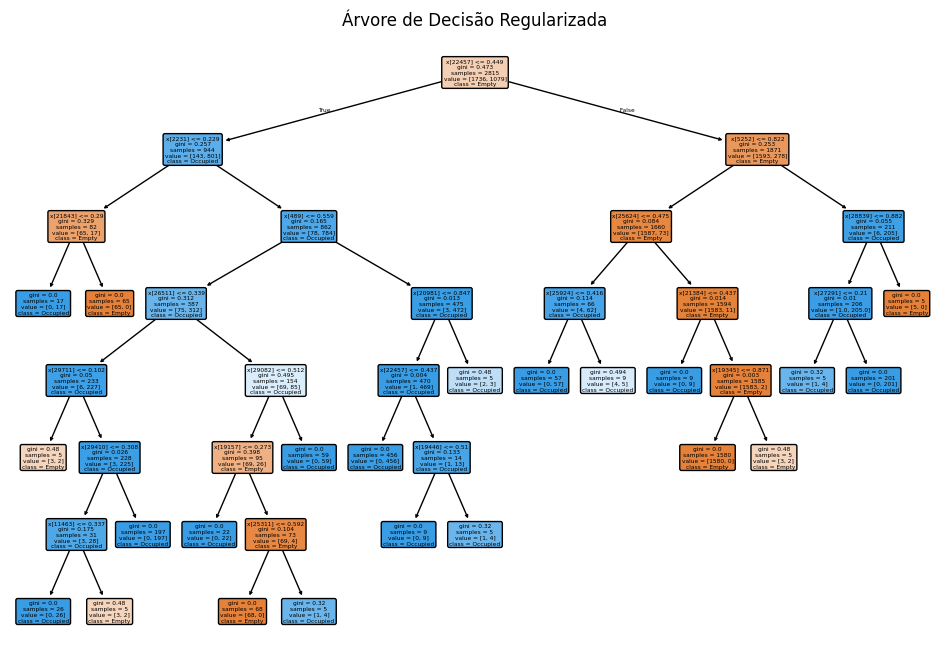

In [34]:
plt.figure(figsize=(12, 8)) 
plot_tree(best_tree, filled=True, feature_names=None, class_names=['Empty', 'Occupied'], rounded=True)
plt.title("Árvore de Decisão Regularizada")
plt.savefig("/home/lavid/JOAO/decision_tree_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Definir o número de folds baseado no tamanho do conjunto de treino
n_samples = x_train.shape[0]  # Número de amostras
n_folds = min(5, n_samples)  # Garantir que o número de folds não seja maior que o número de amostras

# Implementar uma busca em grade com GridSearchCV para encontrar o melhor ccp_alpha
param_grid = {'ccp_alpha': np.linspace(ccp_alphas.min(), ccp_alphas.max(), 5)}

# Configurar a busca em grade com validação cruzada
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=n_folds, n_jobs=-1, verbose=1)

# Executar a busca em grade com validação cruzada
grid_search.fit(x_train, np.argmax(y_train, axis=1))

# Melhor valor de ccp_alpha encontrado
best_tree_grid = grid_search.best_estimator_

# Avaliar a árvore final encontrada pela GridSearchCV no conjunto de validação
y_pred_best_tree_grid = best_tree_grid.predict(x_val)

# Printar o melhor valor de ccp_alpha
print(f"Melhor ccp_alpha encontrado: {grid_search.best_params_['ccp_alpha']}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Melhor ccp_alpha encontrado: 0.0


In [36]:
print("Relatório de Classificação da Árvore GrindSearch:")
print(classification_report(np.argmax(y_val, axis=1), y_pred_best_tree_grid, target_names=['Empty', 'Occupied']))

Relatório de Classificação da Árvore GrindSearch:
              precision    recall  f1-score   support

       Empty       0.98      0.99      0.98      1735
    Occupied       0.98      0.96      0.97      1023

    accuracy                           0.98      2758
   macro avg       0.98      0.97      0.98      2758
weighted avg       0.98      0.98      0.98      2758



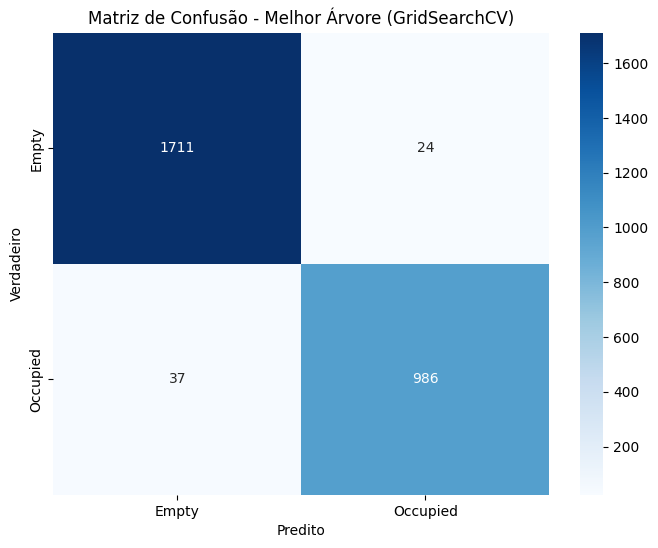

In [37]:
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_best_tree_grid)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Empty', 'Occupied'], yticklabels=['Empty', 'Occupied'])
plt.title('Matriz de Confusão - Melhor Árvore (GridSearchCV)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

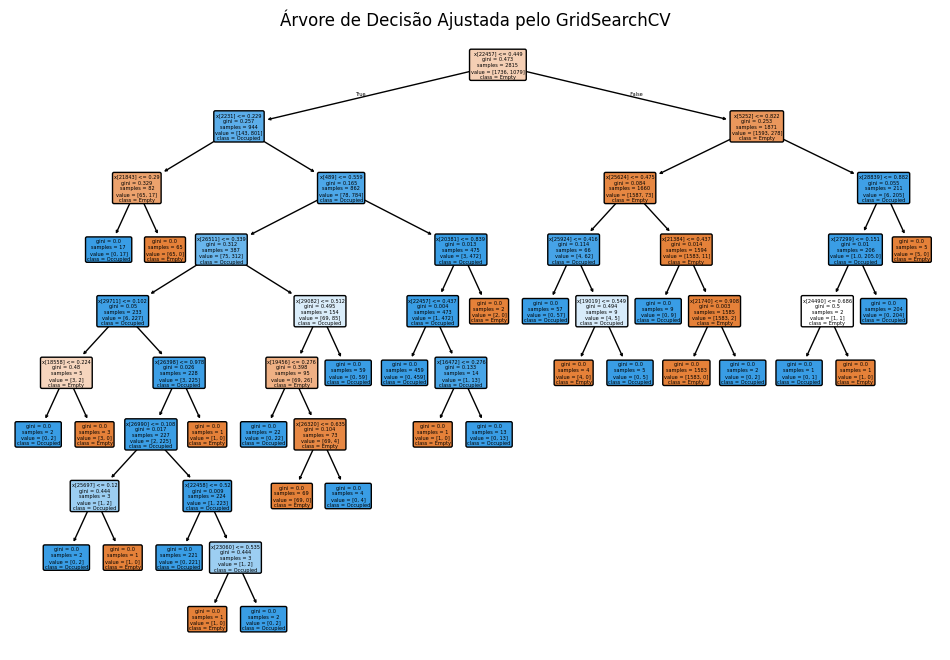

In [38]:
plt.figure(figsize=(12, 8))
plot_tree(best_tree_grid, filled=True, feature_names=None, class_names=['Empty', 'Occupied'], rounded=True)
plt.title("Árvore de Decisão Ajustada pelo GridSearchCV")
plt.savefig("/home/lavid/JOAO/decision_tree_gridsearch.png", dpi=300, bbox_inches='tight')
plt.show()


### SVM

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


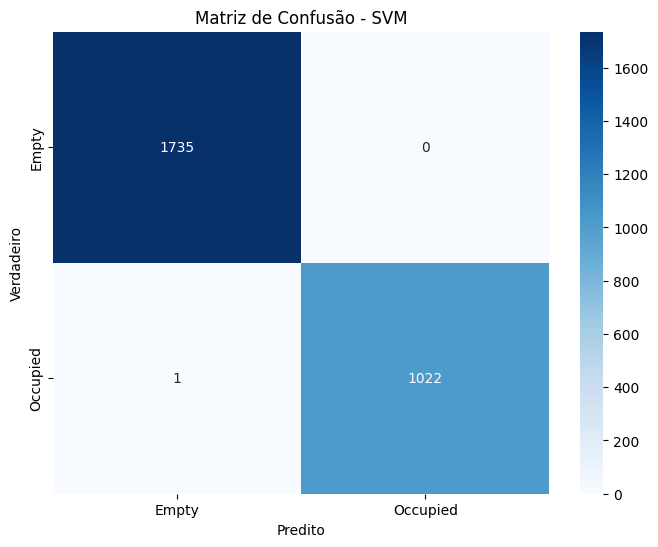

Relatório de Classificação SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1735
           1       1.00      1.00      1.00      1023

    accuracy                           1.00      2758
   macro avg       1.00      1.00      1.00      2758
weighted avg       1.00      1.00      1.00      2758

Melhores parâmetros SVM: {'C': 10, 'gamma': 0.001}


In [39]:
from sklearnex import patch_sklearn
patch_sklearn()  # Isso habilita as otimizações do sklearnex

import os
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Limitar o número de threads para evitar sobrecarga do sistema
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

# Definir os parâmetros para a busca em grade (simplificado para reduzir carga)
param_grid = {
    'C': [1, 5, 10],  # Reduzido o número de valores de C
    'gamma': [0.001, 0.01, 0.1]  # Reduzido o número de valores de gamma
}

# Instanciar o modelo SVM com kernel RBF
svm_model = SVC(kernel='rbf', random_state=42)

# Configurar a busca em grade com validação cruzada (cv=5 para menos iterações)
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, verbose=1)

# Treinar o modelo de SVM
grid_search.fit(x_train, np.argmax(y_train, axis=1))

# Obter as previsões no conjunto de validação
y_pred_svm = grid_search.predict(x_val)

# Gerar a matriz de confusão e o relatório de classificação
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_svm)
cr = classification_report(np.argmax(y_val, axis=1), y_pred_svm)

# Exibir a matriz de confusão usando seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Empty', 'Occupied'], yticklabels=['Empty', 'Occupied'])
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Exibir o relatório de classificação
print("Relatório de Classificação SVM:")
print(cr)

# Exibir os melhores hiperparâmetros encontrados
print(f"Melhores parâmetros SVM: {grid_search.best_params_}")


### Testing model

In [53]:
def make_predictions(image_path, xml_path, classifier=None, display_results=True, nn=False):
    lots, contours = extract_parking_spaces(image_path, xml_path, display_results=True, return_contours=True)
    img = cv2.imread(image_path)
    # Draw a green box if label is occupied, red if it's not
    if classifier is not None:
        for i, lot in enumerate(lots):
            lot = lot.reshape(1,-1)  /  255
            # Use the classifier to make a prediction on the input image
            prediction = classifier.predict(lot)
            if nn:
                prediction = np.argmax(prediction)

            # Draw a green box if label is occupied, red if it's not
            color = (0, 255, 0) if prediction == 1 else (0, 0, 255)
            cv2.drawContours(img, [contours[i]], 0, color, 2)
            
    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img)
        plt.show()

In [54]:
image_path = f'{base_path}/PKLot/PKLot/PUCPR/Cloudy/2012-09-28/2012-09-28_07_16_00.jpg'
xml_path = f'{base_path}/PKLot/PKLot/PUCPR/Cloudy/2012-09-28/2012-09-28_07_16_00.xml'

#### Rede Neural

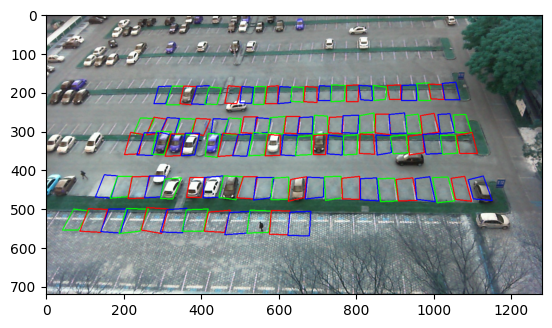

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

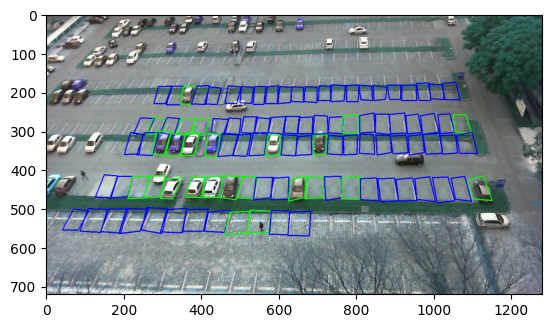

In [55]:
make_predictions(image_path, xml_path, classifier=model, nn=True)

### Árvore de Decisão

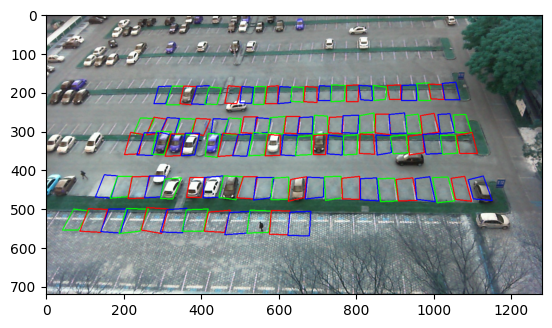

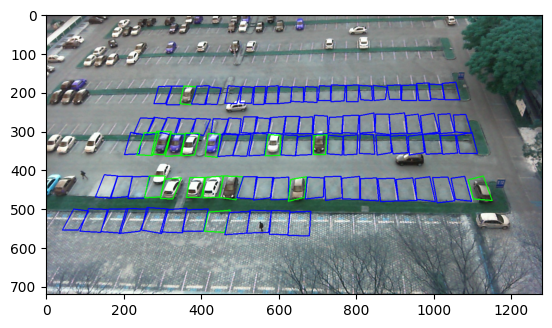

In [56]:
make_predictions(image_path, xml_path, classifier=best_tree_grid)

### SVM

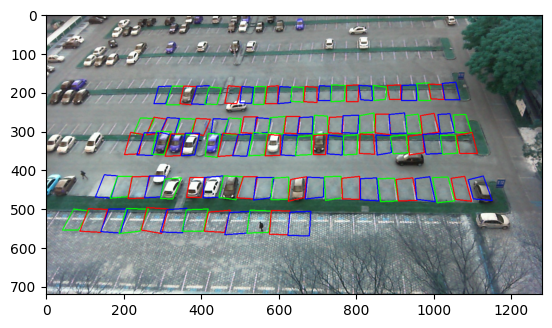

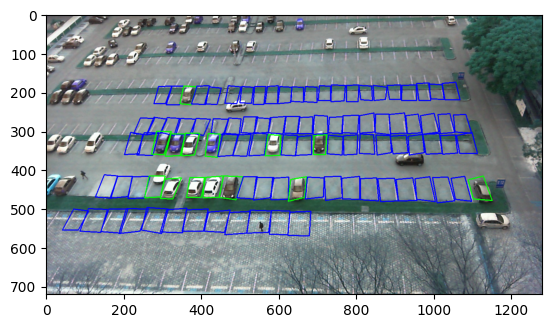

In [57]:
make_predictions(image_path, xml_path, classifier=grid_search)